# Data Analysis in Geoscience Remote Sensing Projects: Exercises -4
## Machine learning
Hendrik Andersen, contact: hendrik.andersen@kit.edu

## Machine learning workflow
Machine learning models are typically used to fit a model with multiple features (predictors or X) to a target/response variable (predictand or y). Frequently, the first task is to prepare and clean the data set (select model features, remove NANs, remove seasonality/trends in the case of geoscience data). After the data is preprocessed and prepared, it needs to be split into a training and a testing subset. The machine learning model is then trained to map the relationships between the predictors and the predictand using the training data set, and evaluated on the unseen test data set. Typically, there are a number of model parameters (hyperparameters) that need to be set (e.g. number of hidden layers/neuros for artificial neural networks, or the number and depth of trees in ensemble tree methods). As the choice of values for model hyperparameters influences the performance of the final model, it is good practice to try to find optimal values for the hyperparameters. This is done during training, typically using a systematic search approach in a cross-validation setup. After the model has been fine-tuned, trained and tested, sensitivity analyses can be conducted (with techniques varying for different machine learning methods).
To summarize, applying a machine learning method to a geoscientific problem for sensitivity analyses, this general workflow can be followed:

1. Prepare the data sets (select the model features/predictors)
2. Split the data into seperate training and test data sets
3. Training of the model, including a fine tuning of the models hyperparameters in a cross-validation setting (within the training data), chose the model hyperparameters 
4. Test the model with independent test data using e.g. R$^2$ statistic and MSE/RSE
5. Conduct sensitivity analyses using explainable AI techniques (feature importance, partial dependencies, shap values)

In the following this general workflow is shown for an ensemble tree method, the Gradient Boosting Regression Tree (GBRT). You may want to additionally check out the great (but slightly goofy) statquest videos on youtube for more information on regression trees in general https://www.youtube.com/watch?v=g9c66TUylZ4 and the playlist for gradient boosting regression trees https://www.youtube.com/watch?v=3CC4N4z3GJc&list=PLblh5JKOoLUJjeXUvUE0maghNuY2_5fY6

In [2]:
# Import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 1. Prepare the data sets
This typically involves a bit of work, but here we use a frequently used already preprocessed example data set to make it easier

In [58]:
# Turn both X and y into a DataFrame and assign the column names, as DataFrames with column names are nice later on.
from sklearn.datasets import fetch_california_housing

cal_housing = fetch_california_housing()
X = cal_housing.data
y = cal_housing.target
X = np.append(X,np.random.rand(y.size,1),axis=1) # add a random variable to the data
cal_housing.feature_names.append('random') # add "random" as variable name
X_df = pd.DataFrame(X, columns=cal_housing.feature_names)
X_df.head()
print(y.shape)
print(X.shape)

(20640,)
(20640, 9)


In [65]:
X

array([[   8.3252    ,   41.        ,    6.98412698, ...,   37.88      ,
        -122.23      ,    0.87174339],
       [   8.3014    ,   21.        ,    6.23813708, ...,   37.86      ,
        -122.22      ,    0.45081366],
       [   7.2574    ,   52.        ,    8.28813559, ...,   37.85      ,
        -122.24      ,    0.99523307],
       ...,
       [   1.7       ,   17.        ,    5.20554273, ...,   39.43      ,
        -121.22      ,    0.88520224],
       [   1.8672    ,   18.        ,    5.32951289, ...,   39.43      ,
        -121.32      ,    0.79349281],
       [   2.3886    ,   16.        ,    5.25471698, ...,   39.37      ,
        -121.24      ,    0.32283818]])

In [69]:
X_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,random
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,0.871743
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,0.450814
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,0.995233
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,0.558568
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,0.134913
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.469166
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.815740
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.885202
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.793493


__Task 1: Data__ 

Use the following webpage (https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset) to find some information on the data contained in the California housing data set.


### 2. Split the data into seperate training and test data sets

In [4]:
# there is a function to split your data into training and test data sets in sklearn
from sklearn.model_selection import train_test_split

# The output are train and test data sets for X and y. 
# test_size is typically between 0.2 and 0.5, depending on the data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [66]:
X_test.shape

(6812, 9)

__Task 2: Separating training and test data__ 

Use the help page of "train_test_split" to see how a) reproducability in results can be achieved, and b) data sets can be split in different ways

### 3. Training the ML model, including hyperparameter tuning

In [5]:
# As a baseline comparison for your ML model, it is always advisable to additionally fit a linear regression model. 
# If your ML model skill in the end is not better than the linear regression, the simple linear regression model is good enough and should be used
from sklearn.linear_model import LinearRegression

# assign the function to a variable name and train the model by calling the method model.fit() 
linear_model = LinearRegression() 
linear_model.fit(X_train, y_train)

LinearRegression()

In [6]:
%%time

# We want to fit a GBRT model and use the algorithm provided by the sklearn package.
from sklearn.ensemble import GradientBoostingRegressor

# assign the function to a variable name and train the model by calling the method model.fit() 
gbrt_model = GradientBoostingRegressor() # by not defining them here, we keep all GradientBoostingRegressor hyperparameters at the default values 
gbrt_model.fit(X_train, y_train) # we see the convenience of having the same syntax for all models in sklearn here

CPU times: total: 5.86 s
Wall time: 6.01 s


GradientBoostingRegressor()

In principle, the defined model has now been trained and can be evaluated and analysed. However, as stated above, it is good practice to tune the hyperparameters in a systematic way. This is now done below. There is more than one way to tune the hyperparameters. Two popular ways are to 
1. do a **full search** over a predefined **grid** of hyperparameter values (defined as "grid" in the cell below)

**Advantage**: The full search is thorough, as all combinations of hyperparameter values are used. 

**Disadvantage**: The curse of dimensionality kicks in: It usually takes a long time to train models for *all* combinations of hyperparameter values. In the example in the cell below, where only some of the hyperparameters are tuned, the number of hyperparameter combinations is $4*4*5*3*3=720$

2. do a **random search** over the same predefined or (as done here) over randomly generated hyperparameter values (defined as "random" in the cell below) for a *predefined number of times* (n_iter)

**Advantage**: The random search is typically much faster, and can yet explore an even larger space of hyperparameter combinations. Also, when values for hyperparameters are randomly drawn for each iteration, a larger number of values is probed for each hyperparameter, so that the probability of reaching a near-optimum setting is higher. This is visualized in the graphic below.  

**Disadvantage**: It is possible that random search will not find as accurate of a result as the full grid search (but not likely!)

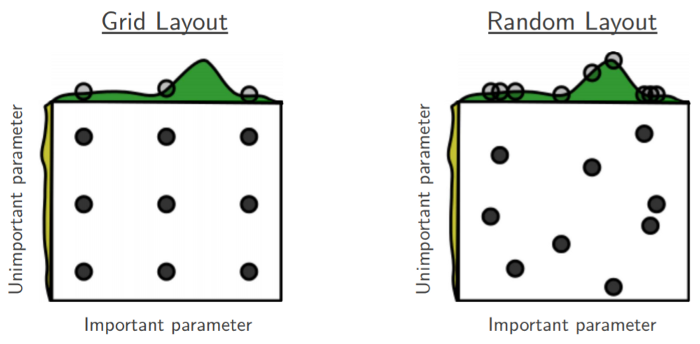

Typically, a random grid search is recommended, which is why the full search is commented out in the cell below. Either way, this is done in a cross-valiation setup. 

In [37]:
%%time

"""
from sklearn.model_selection import GridSearchCV
grid_params = {'learning_rate': [0.01, 0.03, 0.1, 0.3],
        'max_depth': [2,4,6,8],
        'n_estimators': [100,200,300,400,500],
        'subsample':[0.6,0.7,0.8] ,
        'min_samples_split': [3,10,30]
       }
searchcv = GridSearchCV(gbrt_model, grid_params, n_jobs = -1, verbose = 1, cv = 5)
"""

from sklearn.model_selection import RandomizedSearchCV
n_iter = 70 # number of random iterations ---was 100 before by Hendrik Andersen
# here, we define the way the values for the RandomizedSearchCV are drawn for each specific hyperparameter that we want to tune
random_params = {'learning_rate': np.random.uniform(0,1,size = n_iter),
        'max_depth': np.random.randint(3, 10, n_iter),
        'n_estimators': np.random.randint(100, 500, n_iter),
        'subsample':np.random.uniform(0,1,size = n_iter),
        'min_samples_split': np.random.randint(3, 30, n_iter)
         }

# assign the function RandomizedSearchCV to a variable name and train the models in using hyperparameters set in the variable random by calling the method model.fit() 
searchcv = RandomizedSearchCV(gbrt_model, random_params, n_iter = n_iter, n_jobs = -1, verbose = 1, cv = 5)
searchcv.fit(X_train, y_train) # now get a coffee - this may take a while (~16 minutes on my laptop)
# one attribute of RandomizedSearchCV is "best_estimator_", which is the model instance with the combination of hyperparameter values that produced the best results in the cross validation 
best_gbrt_model = searchcv.best_estimator_

Fitting 5 folds for each of 70 candidates, totalling 350 fits
CPU times: total: 26 s
Wall time: 31min 57s


__Task 3.1: Fitting a model__

Check the sklearn website of the GBRT model https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html to find out about

1. the different hyperparameters ('parameters') of the GBRT model and their default values (especially those that are tuned below)
2. the different methods of the GBRT model
3. the different attributes of the GBRT model

In addition to selecting a model with near-optimal hyperparameter values, a systematic search with cross validation lets you explore how the different hyperparameters influence the cross-validation score (these are accessible by the attribute "cv_results_"). This can sometimes help in selecting a better range of values for the hyperparameter tuning (e.g. a higher maximum number of trees). If you spot hyperparameter values that are systematically leading to bad results, these should be excluded from the hyperparameter tuning (by drawing the values in a different way) and the hyperparameter tuning should be conducted again.

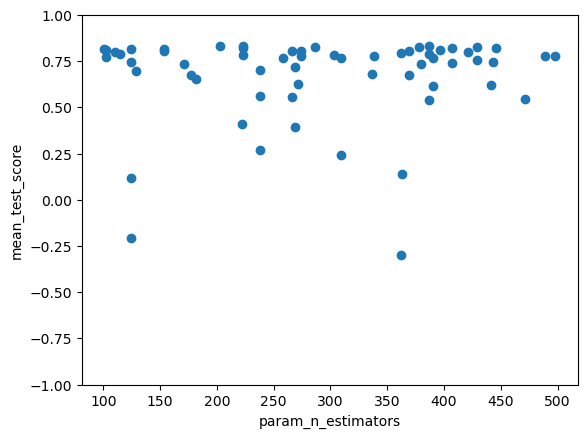

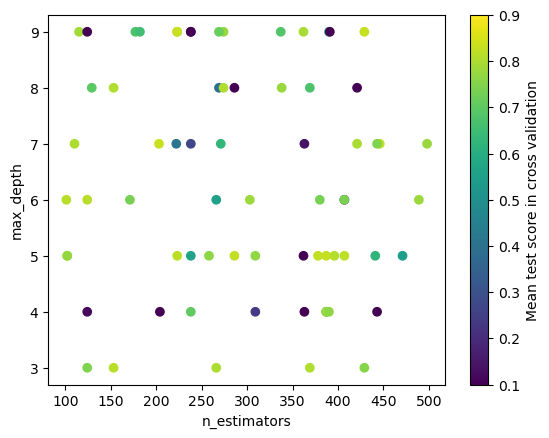

In [40]:
# store the mean test scores of the cross validation in the variable "scores" 
scores = searchcv.cv_results_["mean_test_score"]
# store the maximum depth used in each iteration cross validation in the variable "max_depth"
max_depth = searchcv.cv_results_["param_max_depth"]
# store the number of estimators used in each iteration of the cross validation in the variable "n_estimators"
n_estimators = searchcv.cv_results_["param_n_estimators"]

# you can visualize how a hyperparameter setting is related to the score
plt.scatter(n_estimators,scores)
plt.xlabel("param_n_estimators")
plt.ylabel("mean_test_score")
plt.ylim(-1,1)
plt.show()

# you can also visualize how two hyperparameter settings are related to the score at the same time
plt.scatter(n_estimators, max_depth, c=scores, vmin=0.1, vmax=0.9)
plt.xlabel('n_estimators'); plt.ylabel('max_depth')
plt.colorbar(label='Mean test score in cross validation')
plt.show()

learning_rate = searchcv.cv_results_["param_learning_rate"]
subsample = searchcv.cv_results_["param_subsample"]

__Task 3.2: Fitting a model__

1. Check out the sklearn website of RandomizedSearchCV and GridSearchCV to find out more about their parameters, attributes and methods.
2. Obviously, the hyperparameters n_estimators or max_depth are not driving the variability in the cross-validation score of the models observed. Which hyperparameters are driving the observed variability in cross-validation score? Can we use this information to fine-tune the range from which random data are drawn during hyperparameter tuning? 

## 4) Test the model using the independent test data
Sklearn models have a built-in method "predict" to make predictions based on X. Using this method with the retained X_test subset, we can use our model to predict y_hat. Since we have also retained the original data for y_test that corresponds to X_test, we can use this to evaluate our model. Useful metrics are for example the 
1. Mean squared error (MSE): 
2. Coefficient of determination (R$^2$)

In [41]:
y_hat_gbrt = best_gbrt_model.predict(X_test) # using the optimized GBRT model

from sklearn.metrics import mean_squared_error, r2_score
print('GBRT mean squared error: %.2f' % mean_squared_error(y_test, y_hat_gbrt)) 
print('GBRT coefficient of determination: %.2f' % r2_score(y_test, y_hat_gbrt))
print('GBRT coefficient of determination with the built-in method "score": %.2f' % best_gbrt_model.score(X_test,y_test))

GBRT mean squared error: 0.21
GBRT coefficient of determination: 0.84
GBRT coefficient of determination with the built-in method "score": 0.84


It is also useful and good practice to have look at a scatterplot to get a better feeling for the model skill, and possibly detect outliers/high-leverage points.

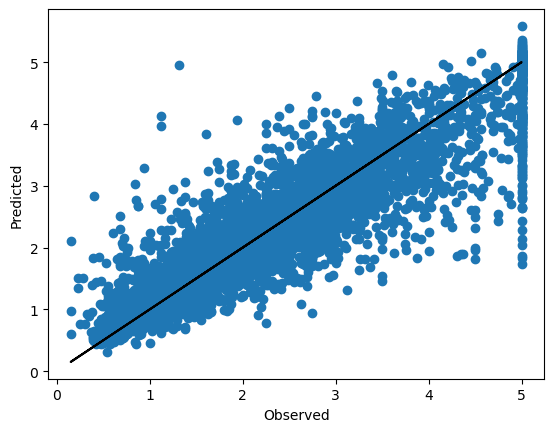

In [42]:
plt.scatter(y_test, y_hat_gbrt)
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.plot(y_test, y_test, color = 'k')
plt.show()

For the number of estimators, specifically, you can track the skill for the training and test skill for each number of estimators. This can also be helpful to fine-tune the range of values for the hyperparameter tuning. In the case below, we see that generally speaking, the model does not improve on the independent test data after ~50 trees (it does improve slightly on the training data, this is called overfitting). 

Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.


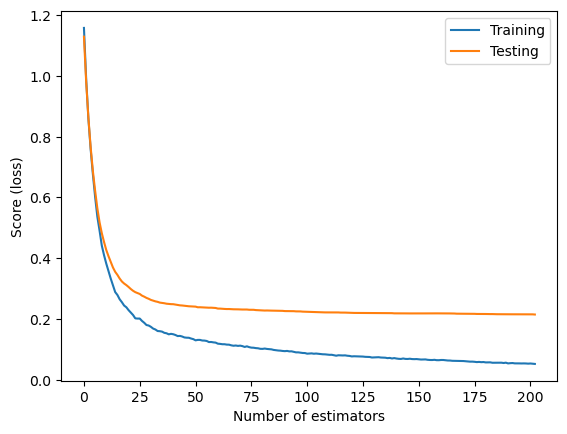

In [67]:
# Compute test score (train score is stored in the model output as the attribute "train_score_")
test_score = np.zeros([best_gbrt_model.n_estimators])
for i, y_hat in enumerate(best_gbrt_model.staged_predict(X_test)):
    test_score[i] = best_gbrt_model.loss_(y_test, y_hat)

# plot train and test scores
plt.plot(best_gbrt_model.train_score_, label='Training')
plt.plot(test_score, label='Testing')
plt.ylabel('Score (loss)')
plt.xlabel('Number of estimators')
plt.legend()
plt.show()

__Task 4__

1. Evaluate the linear regression model in the same manner as the tuned GBRT model is analyzed above. 
2. Compare the linear regression model with the tuned GBRT model - which one is better?

## 5. Sensitivity analysis
After the model has been sufficiently fine-tuned, trained and tested, one can conduct sensitivity analyses. The most popular explainable AI techniques for sensitivity analyses are:
1. Feature importances
2. Partial dependence plots
3. Shap value analyses

### 5.1 Feature importances
Feature importances provide general insights into the model’s behavior, however, they do not provide information as to the sign of the relationship between the feature (predictor) and predictand. There different ways to calculate feature importances. 
1. Impurity-based feature importance (also: Gini importance): This is the standard feature importance that is stored as a model attribute of the GradientBoostingRegressor() in sklearn. It is calculated by going through all the splits in all trees for which a specific feature was used and measure how much it has reduced the variance (Gini index) compared to the prior split (parent node).
2. Permutation feature importance: This importance measure quantifies the increase in model error when the values of a specific feature are permuted (randomly shuffled). 

The permutation feature importance is thought to be more accurate than the impurity-based feature importance, as the impurity-based feature importance has the problem of being biased towards  high cardinality features (features that have many unique values). It is thus advised to use the permutation feature importance.

In [44]:
# Here we print the impurity-based feature importance which is saved within the model object.
print(best_gbrt_model.feature_importances_)

from sklearn.inspection import permutation_importance
pi = permutation_importance(best_gbrt_model, X_test, y_test, random_state=0)
print(pi.importances_mean)

[0.51966195 0.04756973 0.03690426 0.02411144 0.01964783 0.13692673
 0.10319713 0.10293611 0.00904482]
[4.64933262e-01 5.21676048e-02 5.59363073e-02 1.09552068e-02
 8.93384327e-03 1.50934737e-01 1.84889123e+00 1.63879073e+00
 1.71699287e-04]


In [45]:
# Here we create a DataFrame with the feature importance values and feature names for plotting
fi_df = pd.concat([
    pd.DataFrame(X_df.columns, columns=["name"]),
    pd.DataFrame(best_gbrt_model.feature_importances_, columns=["values"])
    ], axis=1)

pi_df = pd.concat([
    pd.DataFrame(X_df.columns, columns=["name"]),
    pd.DataFrame(pi.importances_mean, columns=["values"])
    ], axis=1)

In [51]:
fi_df

,name,values
0,MedInc,0.519662
1,HouseAge,0.047570
2,AveRooms,0.036904
3,AveBedrms,0.024111
4,Population,0.019648
5,AveOccup,0.136927
6,Latitude,0.103197
7,Longitude,0.102936
8,random,0.009045


In [ ]:
pi_df

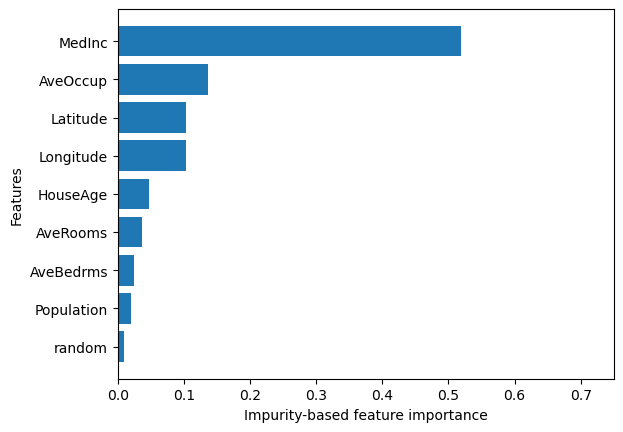

In [46]:
# A barplot can be used to better visualize the feature importance
plt.barh(width = fi_df.sort_values("values")["values"], y = fi_df.sort_values("values")["name"])
plt.xlabel("Impurity-based feature importance")
plt.ylabel("Features")
plt.xlim(0,0.75)
plt.show()

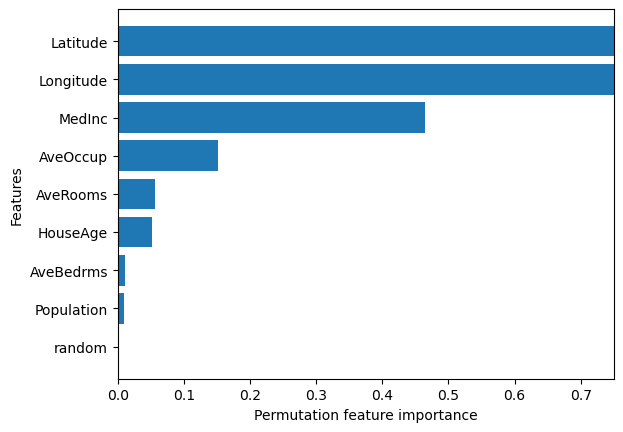

In [47]:
plt.barh(width = pi_df.sort_values("values")["values"], y = pi_df.sort_values("values")["name"])
plt.xlabel("Permutation feature importance")
plt.ylabel("Features")
plt.xlim(0,0.75)
plt.show()

Here we can see how the model feature "random" (which is just randomly generated data) is quantified to have a measureable impurity-based feature importance, while the permutation feature importance does not. This is because "random" has many unique values, which lead to a positive importance bias in the impurity-based feature importance.

### 5.2 Partial dependencies

Partial dependencies quantify the marginal effect of one or two features on the prediction of a machine learning model. The partial dependence function at a particular feature value represents the average prediction when all data points assume that feature value.


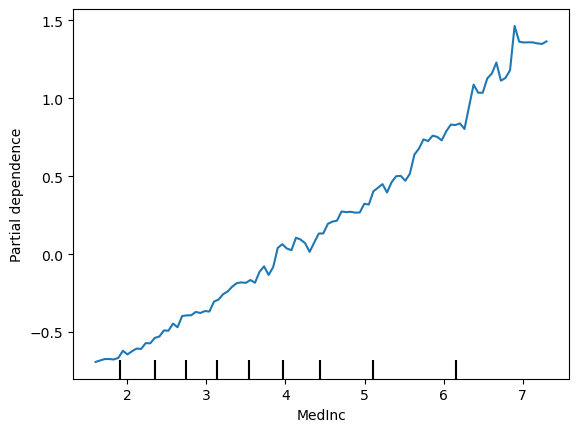

In [48]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(best_gbrt_model, X_df, features=["MedInc"], kind="average", n_jobs=-1,random_state=0)
plt.show()

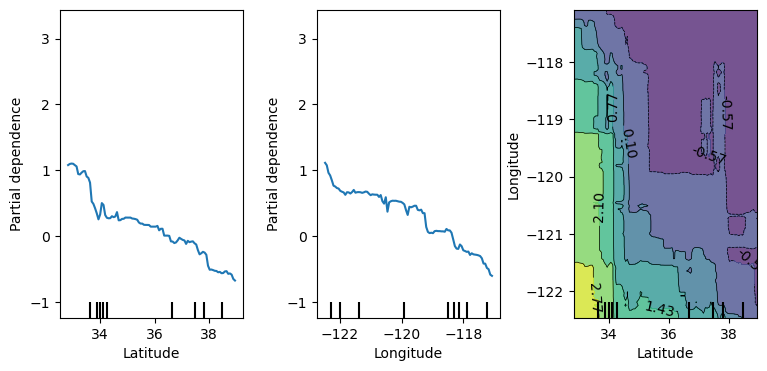

In [49]:

fig, ax = plt.subplots(ncols=3, figsize=(9, 4))
display = PartialDependenceDisplay.from_estimator(best_gbrt_model, X_df, features=["Latitude", "Longitude", ("Latitude", "Longitude")],
    kind=["average", "average", "average"], ax=ax)
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

### 5.3 SHAP values
SHAP values quantify the contribution of each model feature to each specific (local/individual) model prediction (resulting in an array of the dimensions: number of data points x number of features). More precisely, SHAP values quantify the contribution of each model feature to the each model predictions *deviation from the average model prediction*. As such, this answers the question: Why is the model not predicting the average value in this particular example, and what is the influence of this particular feature's value for this deviation? As such, SHAP values can be both positive and negative, depending on the feature value, and are - on average for the entire data set - close to 0. Further information can also be found at https://christophm.github.io/interpretable-ml-book/shap.html.

In [50]:
import shap
# if you cannot import the package shap, you may have to downgrade the numpy version in your conda environment with
# conda install -c conda-forge numpy=1.21
# Then we use two functions provided by the shap package to calculate the SHAP values
explainer = shap.TreeExplainer(best_gbrt_model) # use the fitted model as input here
shap_values = explainer.shap_values(X_df) # use the named X_df DataFrame

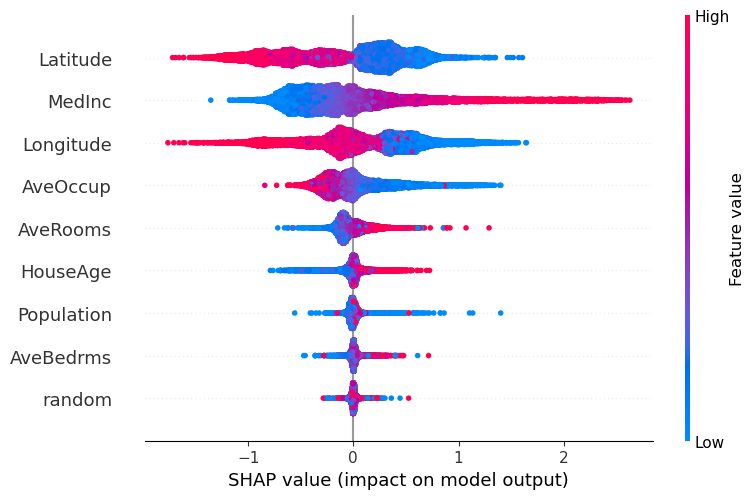

In [31]:
shap.summary_plot(shap_values, X_df)

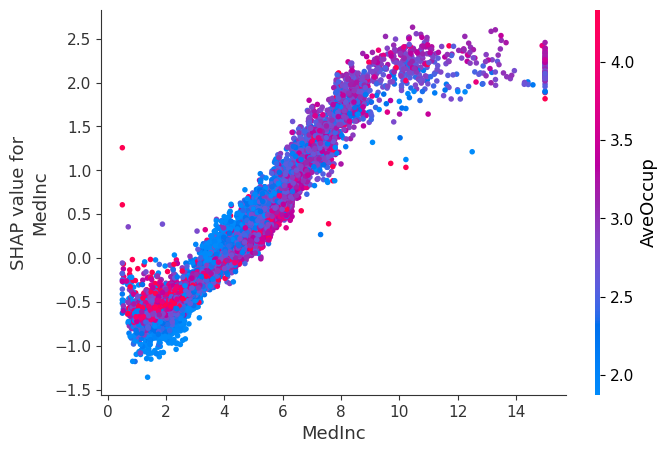

In [32]:
shap.dependence_plot("MedInc", shap_values, X_df) # We can pass the name of the feature or the its index to select the feature we are interested in
# if the colorbar does not show, you may have to downgrade the matplotlib version in your conda environment with
# conda install -c conda-forge matplotlib=3.4.3

**Forceplots** are used to visualize the quantified contributions of each model feature to the prediction of a single data point (one row in the dataset). Here, we draw a force plot for the first data point in the X_df DataFrame using the force_plot() function from the shap package

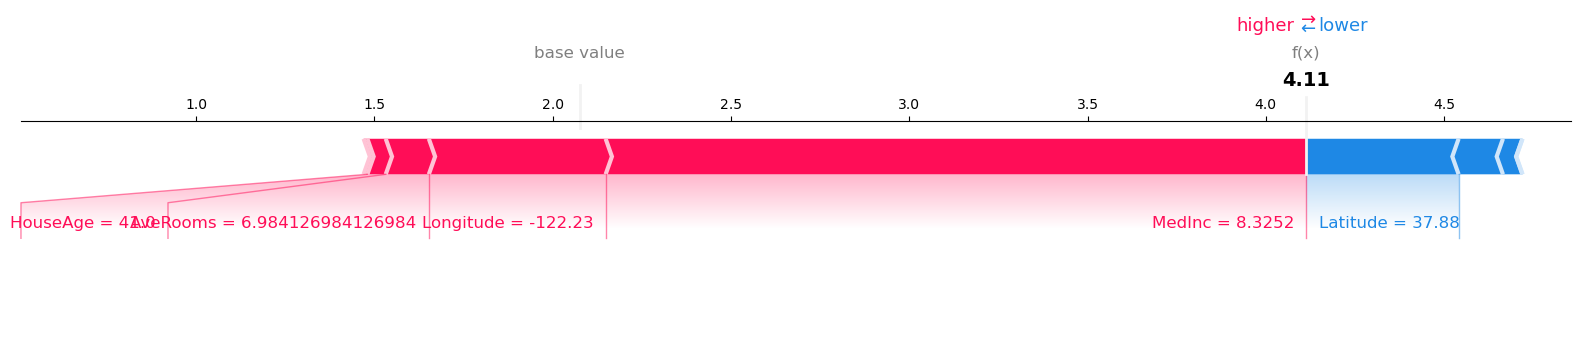

In [33]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_df.iloc[0],matplotlib=True)

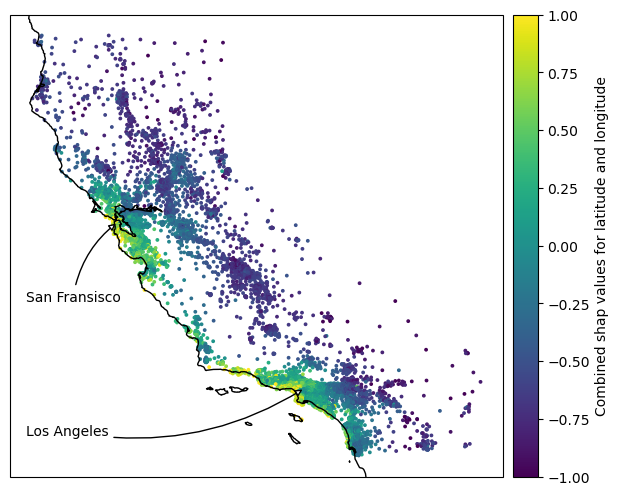

In [34]:
import cartopy.crs as crs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
im = ax.scatter(X_df["Longitude"].values,X_df["Latitude"].values, c = (shap_values[:,-2]+shap_values[:,-3]), s = 3, vmin = -1, vmax = 1)

divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes)
fig.add_axes(ax_cb)
plt.colorbar(im, cax=ax_cb, label='Combined shap values for latitude and longitude')

ax.annotate("San Fransisco", xy=(-122.431297, 37.773972), xycoords='data', xytext=(-124.5, 36), textcoords='data',
                  arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=-0.2", fc="w"),)
ax.annotate("Los Angeles", xy=(-118.243683, 34.052235), xycoords='data', xytext=(-124.5, 33), textcoords='data',
                  arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=0.2", fc="w"),)

plt.show()